In [23]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
import os

In [24]:
def show_image(img, title="Image"):
    if img is None:
        raise ValueError("Image is empty")
    _, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))
    print(title)

In [25]:
def object_detection(img_path, kernel_size=(15, 15), distance_scale=0.625, debug=False):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image at path '{img_path}' could not be loaded.")
    
    original = img.copy()  # Save original for overlaying results later
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, distance_scale * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)

    # Identify unknown regions
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(img, markers)

    # Draw contours and bounding boxes
    labels = np.unique(markers)
    objects = []
    for label in labels:
        if label <= 1:  # Skip background and border markers
            continue
        mask = np.zeros(gray.shape, dtype=np.uint8)
        mask[markers == label] = 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            objects.append(contours[0])

    # Draw detected objects
    img = cv2.drawContours(original, objects, -1, (0, 255, 0), thickness=1)

    # Binaraize the image for filling
    binary = np.zeros_like(img[:,:,0])

    for (x, y, _) in np.argwhere(img==(0,255,0)):
        binary[x, y] = 255



    # Debug visualization
    if debug:
        show_image(thresh, "Thresholded Image")
        show_image(opening, "Morphological Opening")
        show_image(dist_transform.astype(np.uint8), "Distance Transform")
        show_image(sure_fg, "Sure Foreground")
    return [img, binary]

# Usage example


In [26]:
def fill_region_and_export(binary_image, x, y):
    
    
    # Highlight the point on the input image
    image_with_point = cv2.circle(binary_image, (x, y), radius=3, color=128, thickness=-1)
    show_image(image_with_point, "selected point on input image")
    
    # Ensure the input is a binary image
    if len(binary_image.shape) != 2 or binary_image.dtype != np.uint8:
        raise ValueError("Input must be a binary image (2D array of dtype uint8).")

    # Check if the given pixel is inside a contour
    if binary_image[y, x] == 255:
        raise ValueError("The given point is inside a contour")

    # Find all contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour containing the point
    contour_found = False
    for contour in contours:
        if cv2.pointPolygonTest(contour, (x, y), measureDist=False) >= 0:
            contour_found = True
            # Create a mask for the specific contour
            mask = np.zeros_like(binary_image, dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
            show_image(mask, "Output Mask")
            break

    if not contour_found:
        raise ValueError("No contour found containing the given point.")


In [27]:
def get_region_fill_sample():
    # Create a complex binary image with a black background and white contours
    binary_image = np.zeros((400, 400), dtype=np.uint8)

    # Draw multiple white contours for complexity
    cv2.rectangle(binary_image, (50, 50), (150, 150), 255, thickness=2)
    cv2.circle(binary_image, (200, 200), 50, 255, thickness=2)
    cv2.ellipse(binary_image, (300, 300), (60, 40), 0, 0, 360, 255, thickness=2)
    cv2.line(binary_image, (50, 300), (150, 350), 255, thickness=2)
    return binary_image

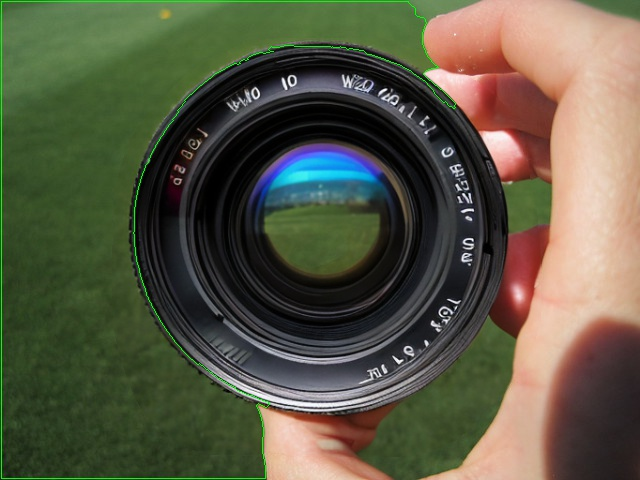

Final Detected Objects


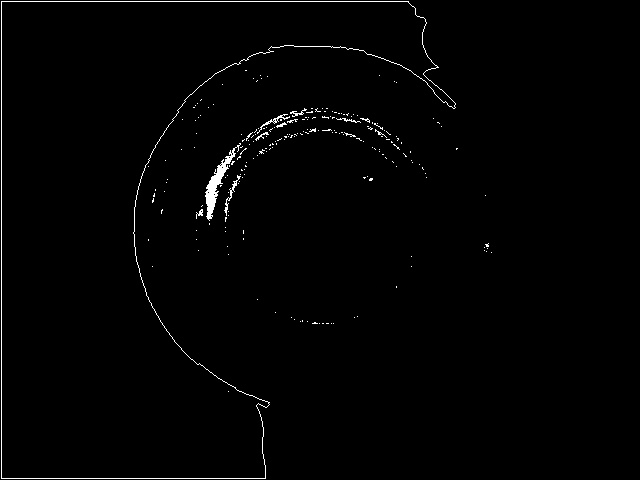

Binary Image


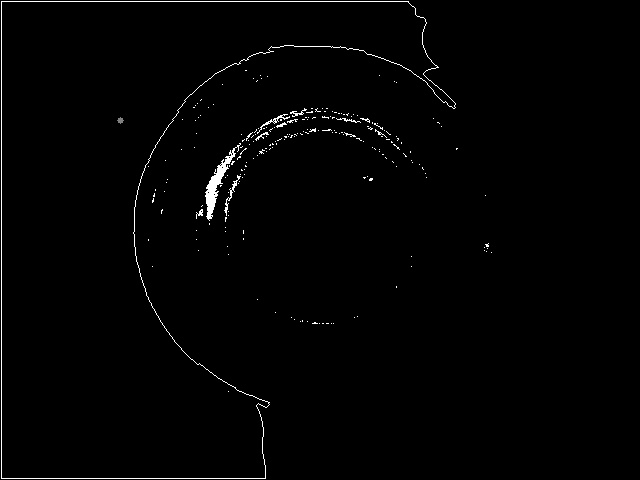

selected point on input image


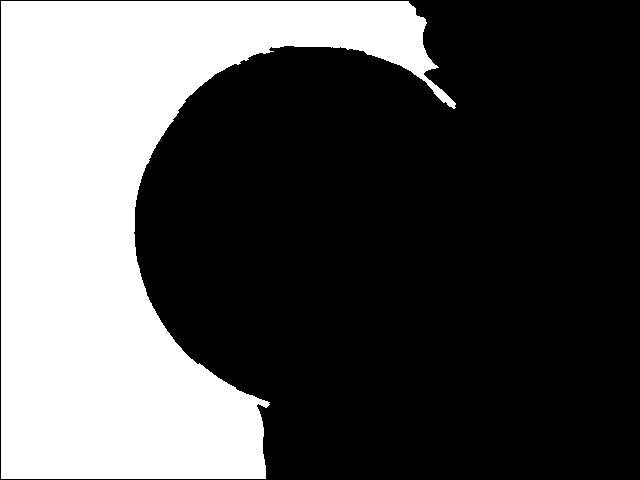

Output Mask


In [28]:
if __name__ == "__main__":
    
    image_path = "../sample_images/camera.png"
    
    result,binary = object_detection(image_path, debug = False)
    show_image(result, "Final Detected Objects")
    show_image(binary, "Binary Image")

    # Coordinates for the point (inside the rectangle)
    x, y = 120, 120

    # Call the function
    fill_region_and_export(binary, x, y)